In [ ]:
import scipy
scipy.__version__

'1.7.3'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import geopandas as gpd

import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import tensorflow as tf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data 102 Final Project
Authors: Russell Algeo, Alex Lee, Liya Zhang, & Santhosh Mathialagan

## Question 1 (GLM)
How did changes in human mobility (other mobility variables in google dataset) impact trends in transit_stations_percent_change? -- (features: retail and recreation percent, grocery and pharmacy percent, parks percent,, workplaces percent, residential percent). Google Data Set (Called US_post_20)

predicting: transit stations percent

Non-parametric: neural network
- Features: retail and recreation percent, grocery and pharmacy percent, parks percent,, workplaces percent, residential percent
- Predict: transit stations percent
- Rationale: NNs are great function approximators that can perform feature engineering without the need of domain knowledge for the data scientist to engineer features. Further, we are predicting a continuous variable so a NN makes more sense here than categorical non-parametric models.
- Assumptions: None 

GLM: Linear Regression (could be changed if we think something works better):
- Features: retail and recreation percent, grocery and pharmacy percent, parks percent, workplaces percent, residential percent
- Predict: transit stations percent
- Assumptions: there is a linear relationship between our input features and predicted features.
- Likelihood: gaussian
- Link-function: identity
- Rationale: Because we are not working with counts data, nor binary data it doesn’t make sense to use logistic regression or poisson / negative-binomial regression.

#### EDA

For this problem, we will be using the Google data set provided on changes in mobility in the United States. Additional data sets we used in this question were geopandas datasets in order to create better visualizations of this data. 

**Data Cleaning Steps**:

To clean the data, we imported each google data set (given in year periods) seperately, and then concatenated them to make one large data set.

In [ ]:
US_20 = pd.read_csv('/work/data/2020_US_Region_Mobility_Report.csv')
US_21 = pd.read_csv('/work/data/2021_US_Region_Mobility_Report.csv')
US_22 = pd.read_csv('/work/data/2022_US_Region_Mobility_Report.csv')

# combine all data for 2020-2022
US_post_20 = pd.concat(objs = [US_20, US_21, US_22])
US_post_20['date'] = pd.to_datetime(US_post_20['date'], format = "%Y-%m-%d")
US_post_20 = US_post_20[US_post_20['date'] < "2022/04/01"]
mobility = US_post_20

In [ ]:
mobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [ ]:
mob_eda = mobility.loc[:, 'retail_and_recreation_percent_change_from_baseline':]
mob_eda.columns = mob_eda.columns.str.extract('(.*)_percent')[0]

In [ ]:
mob_eda.head()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,6.0,2.0,15.0,3.0,2.0,-1.0
1,7.0,1.0,16.0,2.0,0.0,-1.0
2,6.0,0.0,28.0,-9.0,-24.0,5.0
3,0.0,-1.0,6.0,1.0,0.0,1.0
4,2.0,0.0,8.0,1.0,1.0,0.0


Our first visualization we created was a heatmap summarizes various correlation coefficients between columns in the Google Dataset. Here, the darker colors represent a higher (Red = positive, blue = negative) correlation coefficient between variables. 

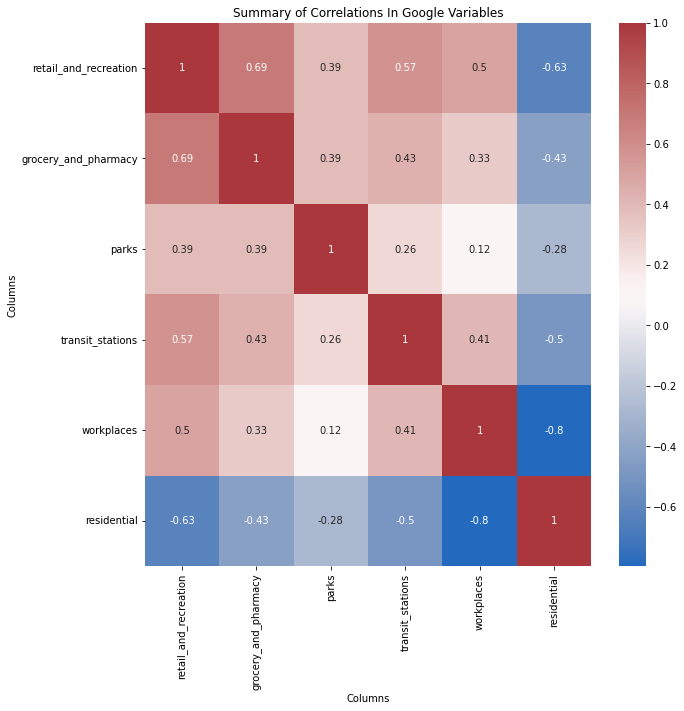

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(mob_eda.corr(), annot = True, ax = ax, cmap = 'vlag')
plt.title('Summary of Correlations In Google Variables')
plt.xlabel('Columns')
plt.ylabel('Columns');

**Analysis + Relevance**: 

We notice that travel to workplace and residential areas have a very strong negative correlation. Resedential and retail and recreation have a moderate negative correlation. Transit stations as well as workplaces have a moderate positive correlation with retail and recreation. Grocery and pharmacy have a strong positive correlation with retail and recreation. 

Given that we are looking to predict transit stations percent change from other variables, the correlations (both positive and negative) with this variable are promissing. 

In [ ]:
mob_geo = gpd.GeoDataFrame(mobility)
mob_geo.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [ ]:
avg_transit_change_by_state = mob_geo.groupby('sub_region_1')['transit_stations_percent_change_from_baseline'].mean()

In [ ]:
avg_transit_change_by_state = avg_transit_change_by_state.reset_index()

In [ ]:
state_geoms = gpd.tools.geocode(avg_transit_change_by_state['sub_region_1'])

In [ ]:
avg_transit_change_by_state[['geometry', 'loc']] = state_geoms

In [ ]:
states = pd.read_csv('/work/States.csv')
states2 = states[states['date'] == '2021-10-22']
states2 = states2[['state']].reset_index(drop = True)

In [ ]:
stateData = states2.merge(avg_transit_change_by_state, how = 'inner', left_on = 'state', right_on = 'sub_region_1')

In [ ]:
from geopandas import GeoSeries, GeoDataFrame
stateGeoCases = gpd.GeoDataFrame(stateData)

In [ ]:
#fig, ax = plt.subplots(1,1)
#avg_transit_change_by_state.plot(column = "transit_stations_percent_change_from_baseline", cmap = 'BuGn', ax = ax, legend = True);
avg_transit_change_by_state

,sub_region_1,transit_stations_percent_change_from_baseline,geometry,loc
0,Alabama,-2.070991,POINT (-86.82953 33.25888),"Alabama, United States"
1,Alaska,-7.725061,POINT (-149.68091 64.44596),"Alaska, United States"
2,Arizona,-0.607085,POINT (-111.76327 34.39534),"Arizona, United States"
3,Arkansas,1.604403,POINT (-92.44791 35.20489),"Arkansas, United States"
4,California,-26.773774,POINT (-118.75600 36.70146),"California, United States"
5,Colorado,-16.263299,POINT (-105.60772 38.72518),"Colorado, United States"
6,Connecticut,-18.174141,POINT (-72.73422 41.65002),"Connecticut, United States"
7,Delaware,-23.664947,POINT (-75.40133 38.69205),"Delaware, United States"
8,District of Columbia,-59.962629,POINT (-76.98804 38.89385),"District of Columbia, United States"
9,Florida,-15.435897,POINT (-81.46398 27.75677),"Florida, United States"


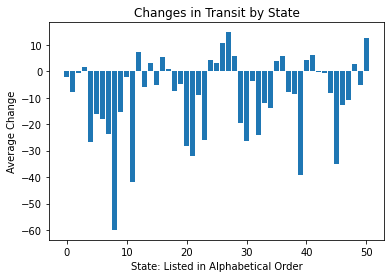

In [ ]:
plt.bar(avg_transit_change_by_state.index, avg_transit_change_by_state['transit_stations_percent_change_from_baseline'])
plt.title('Changes in Transit by State')
plt.xlabel('State: Listed in Alphabetical Order')
plt.ylabel('Average Change');

The following visualization plots the same data as the plot above, except it organizes the states based on their geopandas coordinates (EPSG:4326). 

In [ ]:
states = gpd.read_file('usa-states-census-2014.shp')
states['order'] = [str(index) for index in np.arange(len(states))]
states

,geometry,order
0,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,...",0
1,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04...",1
2,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",2
3,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47...",3
4,"POLYGON Z ((-117.24303 44.39097 0.00000, -117....",4
5,"POLYGON Z ((-91.50617 40.20064 0.00000, -91.49...",5
6,"POLYGON Z ((-96.62187 42.77925 0.00000, -96.57...",6
7,"POLYGON Z ((-89.54443 36.57451 0.00000, -89.47...",7
8,"POLYGON Z ((-94.04305 32.69303 0.00000, -94.04...",8
9,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",9


In [ ]:
state_array = []
for state_poly in states['geometry']:
    for i in range(len(avg_transit_change_by_state)):
        state_point = avg_transit_change_by_state.iloc[i, 2]
        state_name = avg_transit_change_by_state.iloc[i, 0]
        if state_poly.contains(state_point):
            state_array.append(state_name)
            break;
 
        if i == len(avg_transit_change_by_state) - 1:
            state_array.append('Washington')
#state_array

In [ ]:
states['state'] = state_array
states.head()

,geometry,order,state
0,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,...",0,California
1,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04...",1,District of Columbia
2,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",2,Florida
3,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47...",3,Georgia
4,"POLYGON Z ((-117.24303 44.39097 0.00000, -117....",4,Idaho


In [ ]:
states_wdata = states.merge(avg_transit_change_by_state, left_on = 'state', right_on = 'sub_region_1', how = 'left')


In [ ]:
states_wdata = gpd.GeoDataFrame(states_wdata)
states_wdata = states_wdata.rename(columns = {'geometry_x':'geometry'})
states_wdata.head()

,geometry,order,state,sub_region_1,transit_stations_percent_change_from_baseline,geometry_y,loc
0,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,...",0,California,California,-26.773774,POINT (-118.75600 36.70146),"California, United States"
1,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04...",1,District of Columbia,District of Columbia,-59.962629,POINT (-76.98804 38.89385),"District of Columbia, United States"
2,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",2,Florida,Florida,-15.435897,POINT (-81.46398 27.75677),"Florida, United States"
3,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47...",3,Georgia,Georgia,-2.264311,POINT (-83.11374 32.32938),"Georgia, United States"
4,"POLYGON Z ((-117.24303 44.39097 0.00000, -117....",4,Idaho,Idaho,7.115247,POINT (-114.01541 43.64476),"Idaho, United States"


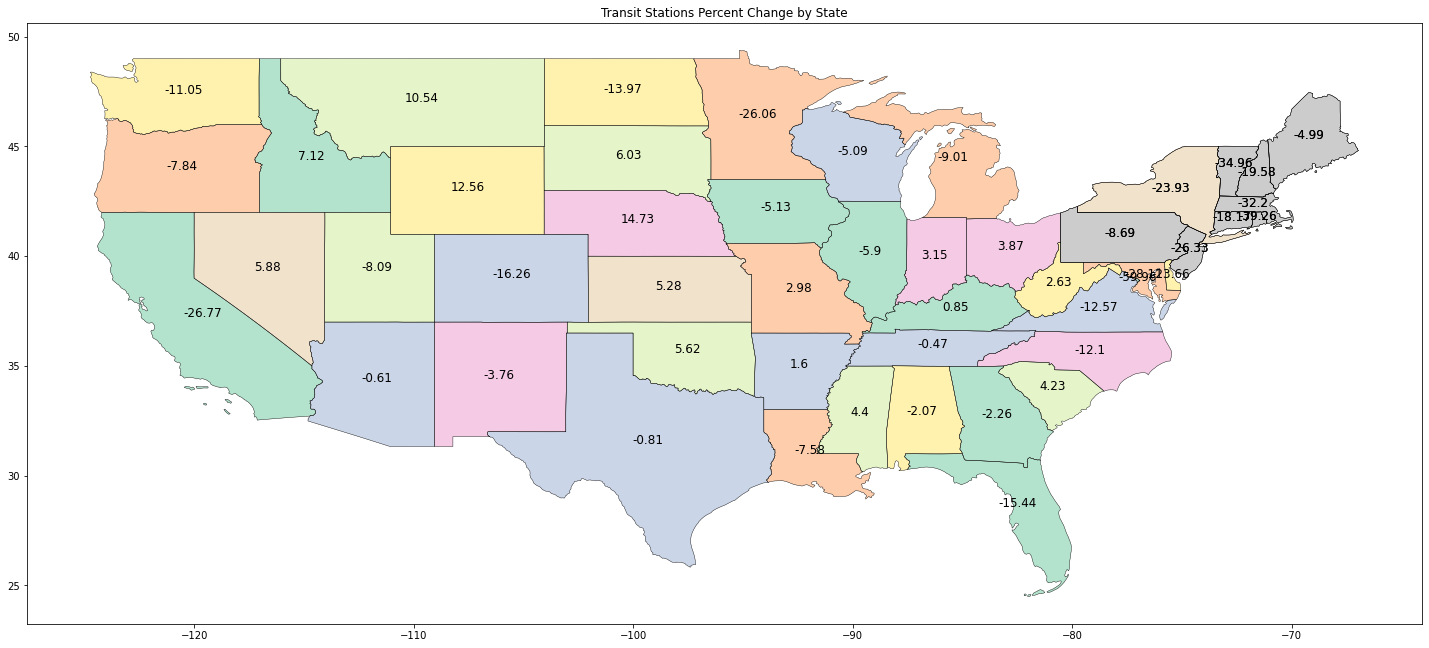

In [ ]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
states_wdata.apply(lambda x: ax.annotate(text=np.round(x.transit_stations_percent_change_from_baseline, 2), xy=x.geometry.centroid.coords[0], ha='center', fontsize=12),axis=1);
states_wdata.boundary.plot(ax=ax, color='Black', linewidth=.4)
states_wdata.plot(ax=ax, cmap='Pastel2', figsize=(12, 12), legend = True)
plt.title('Transit Stations Percent Change by State');


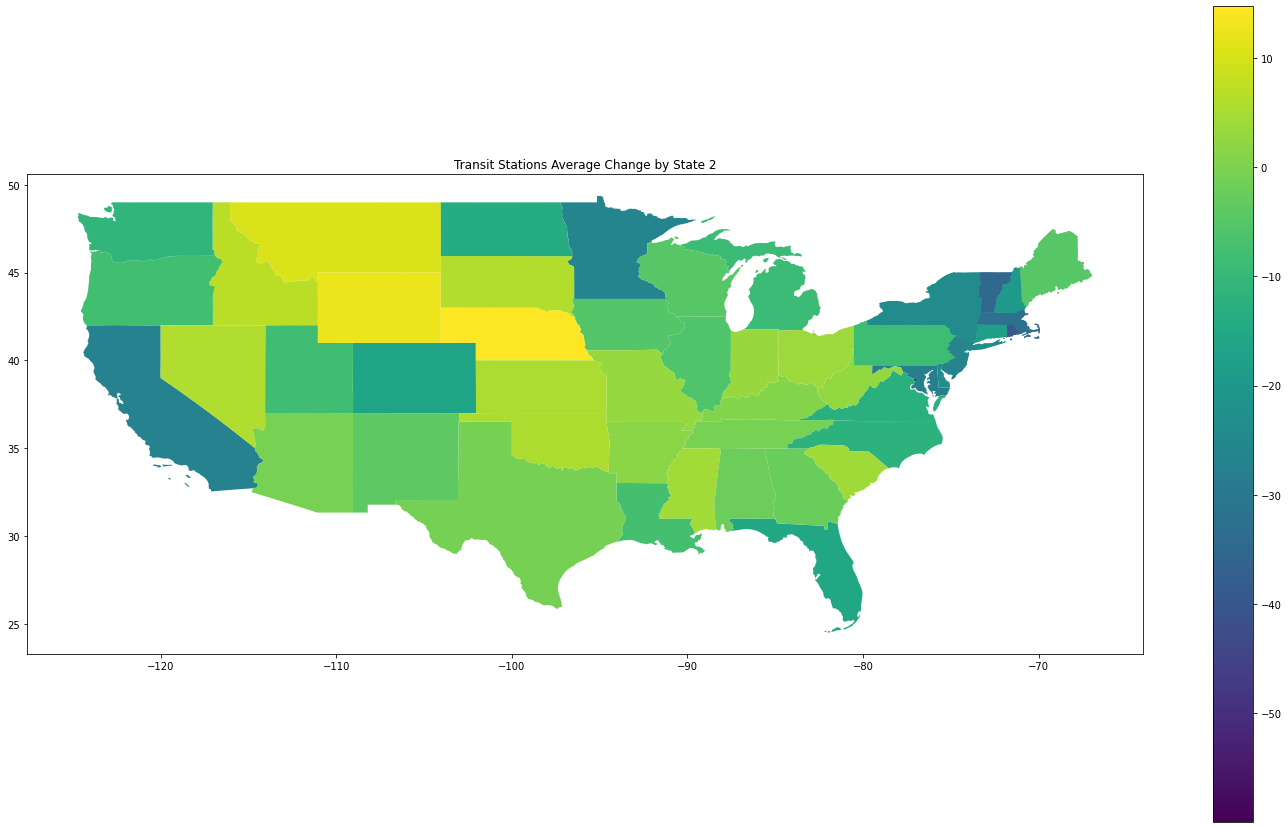

In [ ]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
states_wdata.plot(column='transit_stations_percent_change_from_baseline', ax=ax, legend=True, figsize = (12,12))
plt.title('Transit Stations Average Change by State 2');

In [ ]:
states_wdata['change_sign'] = ['increase in transit' if state_change > 0 else 'decrease in transit' for state_change in states_wdata['transit_stations_percent_change_from_baseline']]


The following graph represents a categorical visualization of transit change. A dark blue state rerpresents ones that decreased on average, and turquoise reoresens states that increase on average. 

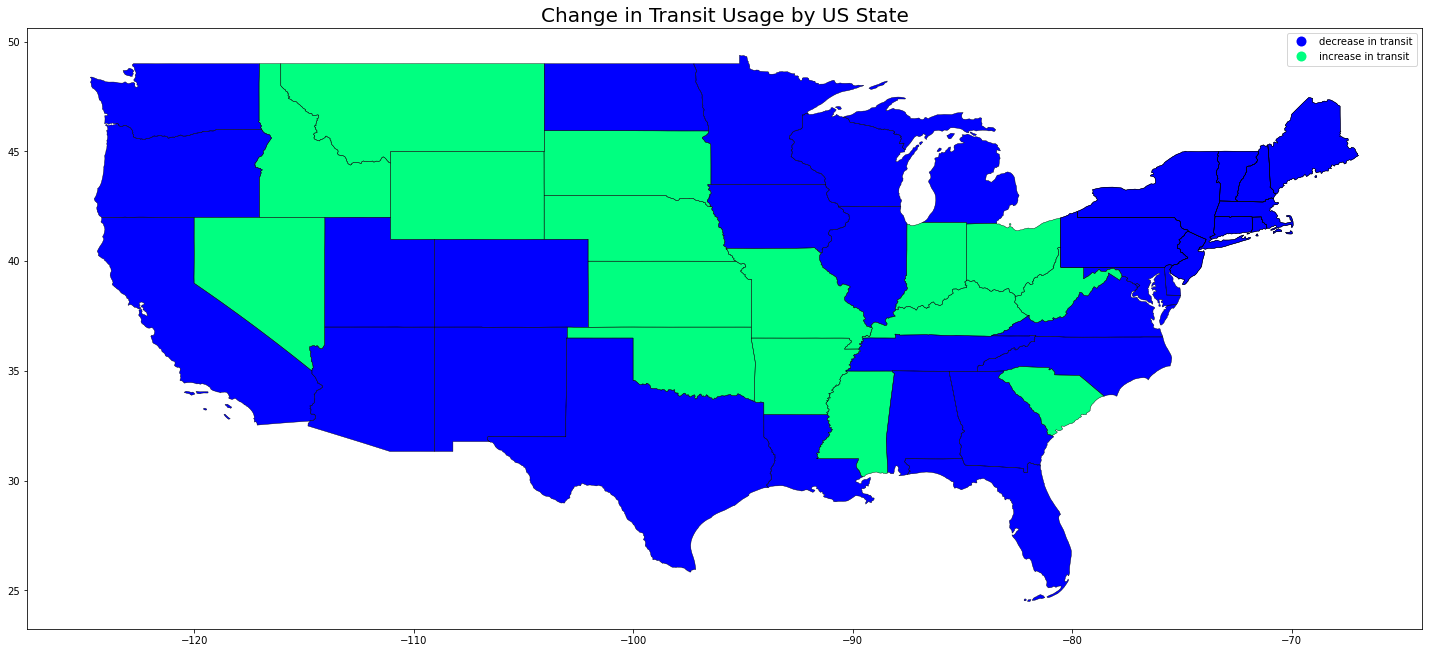

In [ ]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
states_wdata.boundary.plot(ax=ax, color='Black', linewidth=.4)

states_wdata.plot(column='change_sign', ax=ax, legend=True, figsize = (12,12), cmap = 'winter')
plt.title('Change in Transit Usage by US State', fontsize = 20)

params = {'legend.fontsize': 20,
          'legend.handlelength': 2}


Now, we will visualize both the Google Transporation data set and the Government Public Mobility Data Set together (This is the main datasset for question 2).

In [ ]:
gov = pd.read_csv('/work/data/Monthly_Transportation_Statistics.csv')
gov['Date'] = pd.to_datetime(gov['Date'], format = "%d/%m/%Y %H:%M:%S %p")
gov_post_20 = gov[(gov['Date'] >= "2020/01/02 12:00:00") & (gov['Date'] < "2022/01/04 12:00:00")]
spending = gov_post_20.iloc[:, 33:84]
movement = gov_post_20.iloc[:, 6:19]

# 1 
# seen above during import steps
# 2 convert google date to months
US_post_20_copy = US_post_20.copy()
US_post_20_copy['year_month'] = US_post_20_copy['date'].dt.strftime('%Y-%m')
US_post_20_copy = US_post_20_copy.groupby(US_post_20_copy['year_month'], as_index = True).mean()
US_post_20_copy.reset_index(level=0, inplace=True)
US_post_20_copy.pop('metro_area')
US_post_20_copy.head(5)

,year_month,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02,30328.407538,6.145196,2.103233,14.454504,4.253531,-0.086161,0.232813
1,2020-03,30333.737490,-10.379869,5.360028,14.432377,-8.988731,-14.747643,6.571577
2,2020-04,30341.462925,-34.688613,-9.515706,1.069038,-31.144862,-37.378917,16.550969
3,2020-05,30365.031022,-15.271136,2.834255,38.376006,-16.831389,-28.982362,11.671517
4,2020-06,30343.619386,-3.024183,7.141806,68.486314,-5.046891,-22.866399,7.511058


In [ ]:
gov_post_20_copy = gov_post_20.copy() 
gov_post_20_copy['Date'] = gov_post_20_copy['Date'].dt.strftime('%Y-%d')
gov_post_20_copy.head(5)

,Index,Date,Air Safety - General Aviation Fatalities,Highway Fatalities Per 100 Million Vehicle Miles Traveled,Highway Fatalities,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,...,Heavy truck sales SAAR (millions),U.S. Airline Traffic - Total - Non Seasonally Adjusted,Light truck sales SAAR (millions),U.S. Airline Traffic - International - Non Seasonally Adjusted,Auto sales SAAR (millions),U.S. Airline Traffic - Domestic - Non Seasonally Adjusted,Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,U.S. marketing air carriers on-time performance (percent),Transborder - U.S. - Canada Freight
877,877,2020-02,25.0,NaN,NaN,78840000.0,9350000.0,69480000.0,16123791.0,364933382.0,...,456000.0,67830000.0,12609000.0,7960000.0,4272000.0,59870000.0,9.594929e+10,4.845558e+10,0.8,4.749372e+10
878,878,2020-03,17.0,NaN,NaN,37460000.0,4560000.0,32900000.0,10828249.0,260816728.0,...,387000.0,39070000.0,8400000.0,4650000.0,2847000.0,34410000.0,9.881026e+10,5.015464e+10,0.7,4.865562e+10
879,879,2020-04,14.0,1.46,9120.0,3010000.0,140000.0,2870000.0,4303718.0,111044589.0,...,347000.0,3010000.0,6682000.0,140000.0,1932000.0,2880000.0,5.812297e+10,2.835669e+10,0.6,2.976629e+10
880,880,2020-05,21.0,NaN,NaN,7660000.0,180000.0,7480000.0,5481939.0,131468213.0,...,308000.0,8050000.0,9469000.0,190000.0,2661000.0,7860000.0,5.606894e+10,2.536716e+10,0.9,3.070178e+10
881,881,2020-06,30.0,NaN,NaN,15320000.0,350000.0,14970000.0,7149590.0,161043900.0,...,353000.0,16530000.0,10205000.0,400000.0,2890000.0,16130000.0,8.205149e+10,4.159115e+10,0.9,4.046034e+10


In [ ]:
print(US_post_20_copy.shape, gov_post_20.shape)
print(f"US POST 20 DATE RANGE: {US_post_20_copy['year_month'].iloc[0]} TO {US_post_20_copy['year_month'].iloc[-1]}")
print(f"GOV POST 20 DATE RANGE: {gov_post_20_copy['Date'].iloc[0]} TO {gov_post_20_copy['Date'].iloc[-1]}")

(26, 8) (26, 136)
US POST 20 DATE RANGE: 2020-02 TO 2022-03
GOV POST 20 DATE RANGE: 2020-02 TO 2022-03


In [ ]:
data1 = US_post_20_copy.copy()
data1['transport_investment'] = spending.iloc[:,0:14].sum(axis=1).values
data1.pop('year_month')
data1.drop(data1.tail(1).index,inplace=True) # Dropping last row since Transport_investment data missing for March-2022
print(data1.shape)
data1.head(5)

(25, 8)


,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transport_investment
0,30328.407538,6.145196,2.103233,14.454504,4.253531,-0.086161,0.232813,1.903000e+10
1,30333.737490,-10.379869,5.360028,14.432377,-8.988731,-14.747643,6.571577,2.097100e+10
2,30341.462925,-34.688613,-9.515706,1.069038,-31.144862,-37.378917,16.550969,2.383400e+10
3,30365.031022,-15.271136,2.834255,38.376006,-16.831389,-28.982362,11.671517,2.846500e+10
4,30343.619386,-3.024183,7.141806,68.486314,-5.046891,-22.866399,7.511058,3.127800e+10


/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


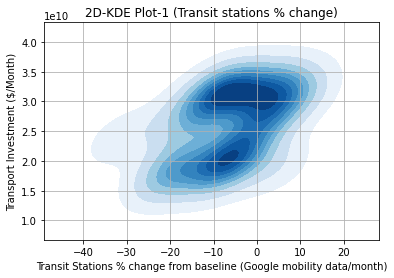

In [ ]:
sns.kdeplot(data1['transit_stations_percent_change_from_baseline'], 
            data1['transport_investment'],
            color='b', shade=True,
            cmap="Blues", shade_lowest=False)
plt.grid()
plt.xlabel('Transit Stations % change from baseline (Google mobility data/month)')
plt.ylabel('Transport Investment ($/Month)')
plt.title("2D-KDE Plot-1 (Transit stations % change)");

#### Analysis for KDE Plot-1
- There are two high density areas at x=-10 to -5; y=1.75 to 2.25 and x=-5 to 0; y=3 to 3.5  <br> 

- The shape of the distribution (positive slope) does suggest that as the Investment in transport is increased, there is an increase in the value of transit_stations_percent_change_from_baseline (from google mobility data). For instance, for a Transport investment of 1.5*e10 the value of transit_stations_percent_change_from_baseline ranges from -30 to 5 whereas for an investment of 3.5*e10 it ranges from -20 to 15. So both the minimum and maximum values of the range increase. <br><br>

- Thus a positive correlation is seen between the two metrics and we can say that we expect to see a positive coefficient for predicting the corresponding regression coefficient (beta) <br><br>

- To obtain the <b> Transport Investment (dollar/month) </b> for all regions combined we directly added the data of following columns from the  government dataset ( <b> State and Local Government Construction Spending - </b>) - Bridge - Lighting - Pavement - Highway and Street - Power - Dock / Marina - Water - Mass Transit - Land Passenger Terminal - Land - Runway - Air Passenger Terminal - Air - Transportation <br><br>

- The mean of all values of "Transit stations % change from baseline" in a month across all regions is taken to obtain the value of "Transit stations % change from baseline" for a particular month for all regions combined <br><br>

- In case data for a particular region is missing in the Google dataset or if it has not been considered in the government dataset (in dollar/month calculation), the inferences might not be true for that region. <br><br>

- The positive correlation between the two variables, supports a causal relationship between transportation investment and transportation utilization (thereby validating our research question). This is because, an increase in the value of "Transit Stations % change from baseline", implies an increase in usage of public transport hubs such as bus/subway/train stations and thus increased utilization of transport when the government investment in transportation is increased. <br><br>

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


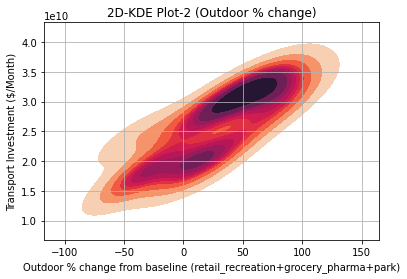

In [ ]:
data1['total_outdoor_percent_change_from_baseline'] = data1['retail_and_recreation_percent_change_from_baseline'] + \
                                                      data1['grocery_and_pharmacy_percent_change_from_baseline']  + \
                                                      data1['parks_percent_change_from_baseline']
sns.kdeplot(data1['total_outdoor_percent_change_from_baseline'], 
            data1['transport_investment'],
            color='r', shade=True,
            cmap="rocket_r", shade_lowest=False)
plt.grid()
plt.xlabel('Outdoor % change from baseline (retail_recreation+grocery_pharma+park)')
plt.ylabel('Transport Investment ($/Month)')
plt.title("2D-KDE Plot-2 (Outdoor % change)");

#### Analysis for KDE Plot 2
- There are two high density areas at x=-25 to 25; y=1.75 to 2.25 and x=50 to 75; y=3 to 3.25  <br><br>
- The shape of the distribution (with a positive slope) implies that as the Investment in transport is increased, there is an increase in the value of total_outdoor_percent_change_from_baseline (calculated from google mobility data). For instance, for a Transport investment of 1.5*e10 the value of total_outdoor_percent_change_from_baseline ranges from -75 to 50 whereas for an investment of 3.5*e10, it ranges from 0 to 125. So both the minimum and maximum values of the range increase with increased government investment in Transportation.<br><br>
- Thus a strong positive correlation is seen between the two metrics (one obtain from google data and the other obtained from government data) and we can say that we expect to see a positive coefficient for predicting the corresponding regression coefficient (beta)<br><br>
- To obtain the <b> Transport Investment (dollar/month) </b> for all regions combined we used the same procedure as described in Analysis for Plot-1<br><br>
- To obtain the <b> Outdoor % change from baseline </b> for all regions combined we added the % change from baseline values in Retail & Recreation, Grocery & Pharma and Parks. Thereafter, the mean of all values of "Outdoor % change from baseline " in a month across all regions is taken to obtain the value of "Outdoor % change from baseline" for a particular month for all regions combined. This variable captures the increase/decrease in mobility trends for all other outdoor places except Workplaces and Residential.<br><br>
- How is this plot relevant to our research question? The idea is that if the government increases investment in Transportation, people would get better transportation facilities and thus would like to use them more often. Where would they go more frequently using better transportation facilities? To one of these outdoor places.  Thus, if they are visiting these outdoor places more often on increasing investment in Transportation, it implies increased Utilization of transport validating our research question. Note that there is no compulsion for people to visit these outdoor places (like a workplace where people have to go every day irrespective of whether they like it or not since they are getting paid for the job). That's why we have not included the workplace in the calculation of "Outdoor % change from baseline". <br><br>
- The positive correlation between the two variables (from the KDE plot)  supports a causal relationship between Transportation investment and Transporation utilization (thereby again validating our research question).<br><br>
- However, we need to be mindful of the fact that causality cannot be concretely established from Observational studies as there might be confounding (hidden) variables. So to eliminate that possibility, we need to consider other possible variables like Covid cases, time of the year, shutdown, etc which might also be the cause for the increase in "Outdoor % change from baseline" and not the Increasing  Government investment in Transportation (which might be a coincidence)


In [ ]:
data1['category_residential_percent_change_from_baseline'] = np.floor((data1['residential_percent_change_from_baseline']\
                                                                       .rank()-1) / len(data1) * 5).astype(int) + 1
    

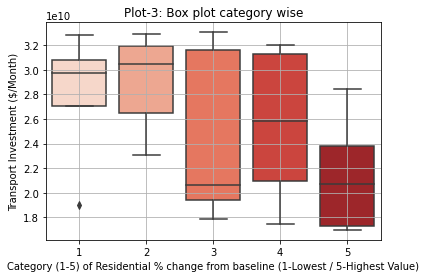

In [ ]:
sns.boxplot(x="category_residential_percent_change_from_baseline",y="transport_investment",data=data1,palette="Reds")
plt.grid()
plt.xlabel('Category (1-5) of Residential % change from baseline (1-Lowest / 5-Highest Value)')
plt.ylabel('Transport Investment ($/Month)')
plt.title("Plot-3: Box plot category wise");

#### Analysis
- There is a clear downtrend in the box plots. So on Decreasing Transport Investment, there is an increase in the Category of "Residential % change from baseline". It means people are staying at Residential places more frequently when investment in Transport is decreased (Dollar/Month).<br><br>
- So the plot suggests Higher the government investment in Transportation, people will stay in residential places less frequently as they probably use the better transportation facilities to stay more frequently at non-residential (outdoor) places. This again supports our research question that there is a positive causal relationship between transportation investment and transportation utilization<br><br>
- To obtain the Category(1-5) of "Residential % change from baseline", we calculate the ranks of all the values, and then the lowest values are assigned Category 1 and the next set of lowest values are assigned Category 2 and so on such that all categories get an almost equal number of data points. Finally the highest values of "Residential % change from baseline" are assigned to Category 5. This way we transform the "Residential % change from baseline" variable from continuous to Categorical with 5 different categories (1-Lowest to 5-Highest value) 

In [ ]:
data1['category_workplaces_percent_change_from_baseline'] = np.floor((data1['workplaces_percent_change_from_baseline']\
                                                                       .rank()-1) / len(data1) * 5).astype(int) + 1
data1.head(5)

,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transport_investment,total_outdoor_percent_change_from_baseline,category_residential_percent_change_from_baseline,category_workplaces_percent_change_from_baseline
0,30328.407538,6.145196,2.103233,14.454504,4.253531,-0.086161,0.232813,1.903000e+10,22.702933,1,5
1,30333.737490,-10.379869,5.360028,14.432377,-8.988731,-14.747643,6.571577,2.097100e+10,9.412535,4,5
2,30341.462925,-34.688613,-9.515706,1.069038,-31.144862,-37.378917,16.550969,2.383400e+10,-43.135282,5,1
3,30365.031022,-15.271136,2.834255,38.376006,-16.831389,-28.982362,11.671517,2.846500e+10,25.939125,5,1
4,30343.619386,-3.024183,7.141806,68.486314,-5.046891,-22.866399,7.511058,3.127800e+10,72.603937,4,2


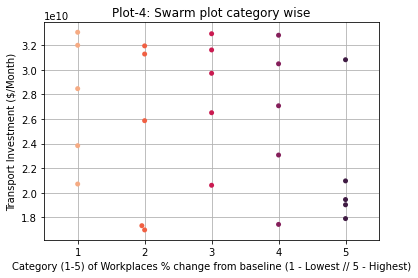

In [ ]:
sns.swarmplot(x="category_workplaces_percent_change_from_baseline",y="transport_investment",data=data1,palette="rocket_r")
plt.grid()
plt.xlabel('Category (1-5) of Workplaces % change from baseline (1 - Lowest // 5 - Highest)')
plt.ylabel('Transport Investment ($/Month)')
plt.title("Plot-4: Swarm plot category wise");

#### Analysis
- From the swarm plot, we observe the data points are all over the place and there is no clear trend <br><br>

- This is in line with our expectations. Increasing investment in transportation should not affect mobility trends for the workplace. This is because people visiting these workplaces are most probably employees who are getting paid to visit the workplace every day. So regardless of whether the transportation facilities are good or bad, they are forced to use them and visit the workplace as it is a part of their job. <br><br>

- Thus this plot suggests that Increased Transportation investment might not imply Increased transport utilization (there might not be a causal relationship) if the transportation is used to commute to workplaces only. <br><br>

- However, if the transportation facilities are being used to commute to other outdoor places (excluding workplaces), we already saw that there might be a strong positive causal relationship between Transport investment and Transport Utilization. <br><br>

- Note that the Category (1-5) of "Workplaces % change from baseline" has been calculated in the same way as the Category (1-5) of "Residential % change from baseline" has been calculated in part-3 (Before analysis of Plot-3) <br><br>

## Results/GLM and Neural Nets

#### Data preparation

In [ ]:
mobility_model = mobility.loc[:, 'retail_and_recreation_percent_change_from_baseline':].dropna()
mob_features = sm.add_constant(mobility_model.drop('transit_stations_percent_change_from_baseline', axis = 1))
mob_targets = mobility_model['transit_stations_percent_change_from_baseline']

In [ ]:
mob_features.head()

,const,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,1.0,6.0,2.0,15.0,2.0,-1.0
1,1.0,7.0,1.0,16.0,0.0,-1.0
2,1.0,6.0,0.0,28.0,-24.0,5.0
3,1.0,0.0,-1.0,6.0,0.0,1.0
4,1.0,2.0,0.0,8.0,1.0,0.0


In [ ]:
mob_targets.head()

0    3.0
1    2.0
2   -9.0
3    1.0
4    1.0
Name: transit_stations_percent_change_from_baseline, dtype: float64

### Frequentist GLM

In [ ]:
gaussian_model_intercept = sm.GLM(mob_targets, mob_features,
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model_intercept.fit()
print(gaussian_results.summary())

                               Generalized Linear Model Regression Results                               
Dep. Variable:     transit_stations_percent_change_from_baseline   No. Observations:               395677
Model:                                                       GLM   Df Residuals:                   395671
Model Family:                                           Gaussian   Df Model:                            5
Link Function:                                          identity   Scale:                          485.82
Method:                                                     IRLS   Log-Likelihood:            -1.7852e+06
Date:                                           Tue, 10 May 2022   Deviance:                   1.9222e+08
Time:                                                   03:43:09   Pearson chi2:                 1.92e+08
No. Iterations:                                                3   Pseudo R-squ. (CS):             0.4409
Covariance Type:                              

In [ ]:
!pip install scikitlearn

ERROR: Could not find a version that satisfies the requirement scikitlearn (from versions: none)
ERROR: No matching distribution found for scikitlearn


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


kfold = KFold(n_splits = 3)
mse = []

for train, test in kfold.split(X = mob_features.values):

    X_train = mob_features.iloc[train, :]
    y_train = mob_targets.iloc[train]

    X_test = mob_features.iloc[test, :]
    y_test = mob_targets.iloc[test]

    y_pred = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit().predict(X_test)

    split_mse = mean_squared_error(y_pred, y_test)
    mse.append(split_mse)

    display(split_mse)

mse = np.mean(mse)

print('KFold CV MSE: ', mse)

302.36308428284804

454.79881769310987

726.5769607198547

KFold CV MSE:  494.5796208986042


#### Bootstrapping for confidence intervals

In [ ]:
import numpy.random as rnd



def bootstrap_xy(X, y, fnc, B=10):
    d = X.shape[1]
    N = X.shape[0]
    w_boot = np.zeros(shape=(B,d))
    for b in range(B):
        bootstrap_indices = rnd.choice(np.arange(N), N)
        bootstrap_X = X.iloc[bootstrap_indices, :]
        bootstrap_y = y.iloc[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    
    return w_boot

def freq_GLM(X, y):
    gaussian_model_intercept = sm.GLM(y, X, family=sm.families.Gaussian())
    return gaussian_model_intercept.fit().params

freq_GLM_bootstrap = bootstrap_xy(mob_features, mob_targets, freq_GLM)

In [ ]:
np.round(np.percentile(freq_GLM_bootstrap, 2.5, axis = 0), 3)

array([-1.335,  0.566,  0.14 ,  0.022,  0.141, -0.816])

In [ ]:
np.round(np.percentile(freq_GLM_bootstrap, 50.0, axis = 0), 3)

array([-1.186,  0.571,  0.147,  0.024,  0.152, -0.793])

In [ ]:
np.round(np.percentile(freq_GLM_bootstrap, 97.5, axis = 0), 3)

array([-1.14 ,  0.579,  0.153,  0.024,  0.161, -0.764])

To address our first question of how various trends in mobility patterns affects public transit usage, one of the models we developed was a Linear GLM. We assumed a linear realationship between our features and targets, and chose to use a Linear GLM because we are not working with counts or binary data. 

In the results of our model, we see that the model overall fit the data extremely well due to a very low log likelihood. We found that all mobility trends had a positive correlation with transit station usage besides increases in residential living. Increase in reatail and recreastion mobility trends had the highest impact on transit, with a 1 percent increase in retail and recreation corresponding to a 0.57 percent increase in transit station usage.

### Bayesian GLM (Pymc3)

In [ ]:
mob_features.columns

Index(['const', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [ ]:
# 'retail_and_recreation_percent_change_from_baseline': pm.Normal.dist(mu=0, tau=1),
#                 'grocery_and_pharmacy_percent_change_from_baseline': pm.Normal.dist(mu=0, tau=1),
#                 'parks_percent_change_from_baseline': pm.Normal.dist(mu=0, tau=1),
#                 'workplaces_percent_change_from_baseline': pm.Normal.dist(mu=0, tau=1),
#                 'residential_percent_change_from_baseline': pm.Normal.dist(mu=0, tau=1)
                

formula = 'target ~ ' + ''.join([column + ' + ' for column in mob_features.columns])
formula[:-3]

'target ~ const + retail_and_recreation_percent_change_from_baseline + grocery_and_pharmacy_percent_change_from_baseline + parks_percent_change_from_baseline + workplaces_percent_change_from_baseline + residential_percent_change_from_baseline'

In [ ]:
pm_mob = mob_features.assign(target = mob_targets).iloc[:, 1:]

In [ ]:
pm_mob.columns = ['retail_and_recreation',
       'grocery_and_pharmacy',
       'parks',
       'workplaces',
       'residential', 'target']
pm_mob

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,target
0,6.0,2.0,15.0,2.0,-1.0,3.0
1,7.0,1.0,16.0,0.0,-1.0,2.0
2,6.0,0.0,28.0,-24.0,5.0,-9.0
3,0.0,-1.0,6.0,0.0,1.0,1.0
4,2.0,0.0,8.0,1.0,0.0,1.0
...,...,...,...,...,...,...
243183,-6.0,-8.0,80.0,-8.0,-1.0,9.0
243184,-12.0,-10.0,52.0,-31.0,2.0,5.0
243185,-18.0,-15.0,-21.0,-30.0,5.0,7.0
243186,-10.0,-13.0,17.0,-30.0,3.0,1.0


In [ ]:
formula = 'target ~ ' + ''.join([column + ' + ' for column in pm_mob.columns[:-1]])[:-3]
formula


In [ ]:
import arviz as az
import bambi as bmb

# Formula
formula = 'target ~ ' + ''.join([column + ' + ' for column in pm_mob.columns[:-1]])[:-3]

# Initialize the fixed effects only model
model = bmb.Model(formula, pm_mob)

# Fit the model using 1000 on each of 4 chains
results = model.fit(draws=100, chains=1)

# Use ArviZ to plot the results
az.plot_trace(results)

# Key summary and diagnostic info on the model parameters
az.summary(results)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/root/venv/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, residential_percent_change_from_baseline, Intercept]


/root/venv/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/root/venv/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/root/venv/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/root/venv/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


RuntimeError: Chain 1 failed.

### Neural Network (Keras/TensorFlow)

In [ ]:
np.savez('mob_nn',input=mob_features, targets=mob_targets)
training_data=np.load('mob_nn.npz')

In [ ]:
training_data['input']

array([[  1.,   6.,   2.,  15.,   2.,  -1.],
       [  1.,   7.,   1.,  16.,   0.,  -1.],
       [  1.,   6.,   0.,  28., -24.,   5.],
       ...,
       [  1., -18., -15., -21., -30.,   5.],
       [  1., -10., -13.,  17., -30.,   3.],
       [  1., -12., -14.,   5., -29.,   2.]])

In [ ]:
mob_targets

0          3.0
1          2.0
2         -9.0
3          1.0
4          1.0
          ... 
243183     9.0
243184     5.0
243185     7.0
243186     1.0
243187    20.0
Name: transit_stations_percent_change_from_baseline, Length: 395677, dtype: float64

In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X = mob_features.values
Y = mob_targets

def baseline_model():
	model = Sequential()
	model.add(Dense(mob_features.shape[1], input_dim=mob_features.shape[1], kernel_initializer='normal', 
                activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=200, verbose=1)
kfold = KFold(n_splits=4)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
Epoch 1/10
1484/1484 [==============================] - 8s 4ms/step - loss: 607.7310
Epoch 2/10
1484/1484 [==============================] - 6s 4ms/step - loss: 554.0983
Epoch 3/10
1484/1484 [==============================] - 6s 4ms/step - loss: 552.2124
Epoch 4/10
1484/1484 [==============================] - 6s 4ms/step - loss: 550.5906
Epoch 5/10
1484/1484 [==============================] - 6s 4ms/step - loss: 548.8572
Epoch 6/10
1484/1484 [==============================] - 6s 4ms/step - loss: 546.9744
Epoch 7/10
1484/1484 [==============================] - 7s 5ms/step - loss: 545.3076
Epoch 8/10
1484/1484 [==============================] - 6s 4ms/step - loss: 543.8497
Epoch 9/10
1484/1484 [=====================

#### <u>Research Questions</u>

Your research questions should involve using the methods mentioned above (i.e., the ones you’ve learned in DATA 102) to answer them. For each of your two research questions, describe
- What is the research question? What real-world decision(s) could be made by answering it?
- Explain why the method you will use is a good fit for the question (for example, if you choose causal inference, you should explain why the causal inference is a good fit for answering your research question)


##### <u>Research QUESTION 1</u>: <br><br> How did changes in human mobility* impact trends in the transit_stations_percent_change_from_baseline? <br>

*mobility variables used from google dataset: 
- retail_and_recreation_percent_change_from_baseline, 
- grocery_and_pharmacy_percent_change_from_baseline, 
- parks_percent_change_from_baseline, 
- workplaces_percent_change_from_baseline, 
- residential_percent_change_from_baseline 

##### METHOD USED to answer Research Question 1 – <b><u> Generalized Linear Model (GLM) </u></b>

##### What real-world decision(s) could be made by answering Research QUESTION 1 ?

- Answering the research question helps us to understand how the other mobility variables impact the transit_stations_percent_change. 
- Also, which mobility variables have the greatest and the least positive and negative influence on transit_stations_percent_change can be known by answering the research question. 
- This information can be of great value in real-world decision-making. For instance, if we have sufficient evidence to believe that there will be a big increase in retail_and_recreation_percent in a particular month in the future, then we can estimate the impact it will have on transit_stations_percent_change. 
- Correspondingly, we can use this knowledge to determine the appropriate investments government should make in not only the transit stations but also in overall transportation facilities. This is because, an increase in mobility trends for transit_stations_percent_change implies increased transport utilization and vice versa.

##### Why GLMs are a good fit to answer Research QUESTION 1 ? 

- GLMs are a good fit for the question because there are multiple predictor variables. 
- The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.
- Results of GLMs are easy to interpret. GLMs give a clear understanding of how each of the mobility variables is influencing the transit_stations_percent_change in a completely unbiased way. So, the results are also reliable. 
- However, the assumption we are making is that there is a linear relationship between our predictor variables (from google mobility data) and the outcome variable (transit_stations_percent_change)


##### <u> Research QUESTION 2</u>: <br><br> Is there a causal relationship between transportation investment* and transportation utilization**?  <br>

*<b>transportation investment: </b> To estimate for all regions combined we directly added the data of following columns from the  Government dataset ( <b> State and Local Government Construction Spending - </b>) - Bridge - Lighting - Pavement - Highway and Street - Power - Dock / Marina - Water - Mass Transit - Land Passenger Terminal - Land - Runway - Air Passenger Terminal - Air - Transportation 

**<b>transportation utilization: </b> To estimate transport utilization in a month, we calculate <b> Outdoor % change from baseline </b> for all regions combined. We added the % change from baseline values in Retail & Recreation, Grocery & Pharma, and Parks from the Google mobility dataset. Thereafter, the mean of all values of "Outdoor % change from baseline " in a month across all regions is taken to obtain the value of "Outdoor % change from baseline" for a particular month for all regions combined. This variable captures the increase/decrease in mobility trends for all other outdoor places except Workplaces and Residential.

##### METHOD USED to answer Research Question 2 – <b><u> Causal Inference </u></b>

In the Causal Inference studies for the research question, the Treatment variable is: Transportation Investment and the Outcome variable is: Transportation Utilization

### Question 2 (Causal Inference)
Is there a causal relationship between transportation investment and transportation utilization?

gov_post_20 data set


- Treatment: investment into transportation measures
- Outcome: utilization rates of transportation measures
- Units: We have not decided on a final metric to predict but will likely be in percent change/day 
- Confounders: Covid cases, time of year, shutdowns

#### EDA

##### Data Cleaning

Government Public Mobility Data Set

In [ ]:
gov = pd.read_csv('/work/data/Monthly_Transportation_Statistics.csv')
gov['Date'] = pd.to_datetime(gov['Date'], format = "%d/%m/%Y %H:%M:%S %p")

In [ ]:
# one month per row
gov_post_20 = gov[(gov['Date'] >= "2020/01/01 12:00:00") & (gov['Date'] <= "2021/01/12 12:00:00")]
spending = gov_post_20.iloc[:, 33:84]
movement = gov_post_20.iloc[:, 6:19]

In [ ]:
# cleaning column names
names = []
for col in list(spending.columns):
    new = col.split(' - ')[1]
    names.append(new)
spending.columns = names

# re-indexing to number of months since Jan 2020
spending = spending.dropna(axis = 0)
spending = spending.reset_index(drop = True)
movement = movement.dropna(axis = 0)
movement = movement.reset_index(drop = True)

In [ ]:
# restricting to just airline related columns in spending and movement dataframes
air_spend = spending.loc[:, 'Land Passenger Terminal':'Air']
air_spend['Total Spend'] = air_spend.sum(axis = 1)
air_move = movement.loc[:, 'U.S. Airline Traffic - International - Seasonally Adjusted':'U.S. Airline Traffic - Domestic - Seasonally Adjusted']
air_move['Total Move'] = air_move.sum(axis = 1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# adding categorical column indicating if each month had above, or below average air line spending
mean_air_spend = np.mean(air_spend['Total Spend'])
big_spend = air_spend['Total Spend'] >= mean_air_spend
air_move['High Spend'] = big_spend.astype(int)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


CDC Covid Cases Data Set

In [ ]:
covid_cases = pd.read_csv('/work/data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
covid_cases['submission_date'] = pd.to_datetime(covid_cases['submission_date'], format = "%m/%d/%Y")

In [ ]:
# filter to same date range as available government spending / mobility date
covid_cases = covid_cases[(covid_cases['submission_date'] >= "2020/01/01 12:00:00") & (covid_cases['submission_date'] <= "2021/12/1 12:00:00")]

In [ ]:
# group by month and year so that data at same granularity as government mobility / spending data
covid_by_month = covid_cases.groupby(by = [covid_cases['submission_date'].dt.year, covid_cases['submission_date'].dt.month], as_index = True).sum()
# filter to data point of interest: new cases
covid_by_month = covid_by_month['new_case']
covid_by_month = covid_by_month.reset_index(drop = True)

In [ ]:
# combine into one data frame with relevant air line data, and covid data
air_data = air_spend.join(air_move).join(covid_by_month)
air_data.head()

,Land Passenger Terminal,Land,Runway,Air Passenger Terminal,Air,Total Spend,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Total Move,High Spend,new_case
0,108000000.0,1.260000e+09,303000000.0,9.970000e+08,1.374000e+09,4.042000e+09,9680000.0,69910000.0,79590000.0,0,4
1,106000000.0,1.267000e+09,302000000.0,1.000000e+09,1.395000e+09,4.070000e+09,9350000.0,69480000.0,78830000.0,0,66
2,110000000.0,1.279000e+09,308000000.0,1.156000e+09,1.555000e+09,4.408000e+09,4560000.0,32900000.0,37460000.0,0,212391
3,103000000.0,1.267000e+09,423000000.0,1.144000e+09,1.652000e+09,4.589000e+09,140000.0,2870000.0,3010000.0,0,876478
4,103000000.0,1.494000e+09,495000000.0,1.310000e+09,1.894000e+09,5.296000e+09,180000.0,7480000.0,7660000.0,1,744102


#### Visualizations

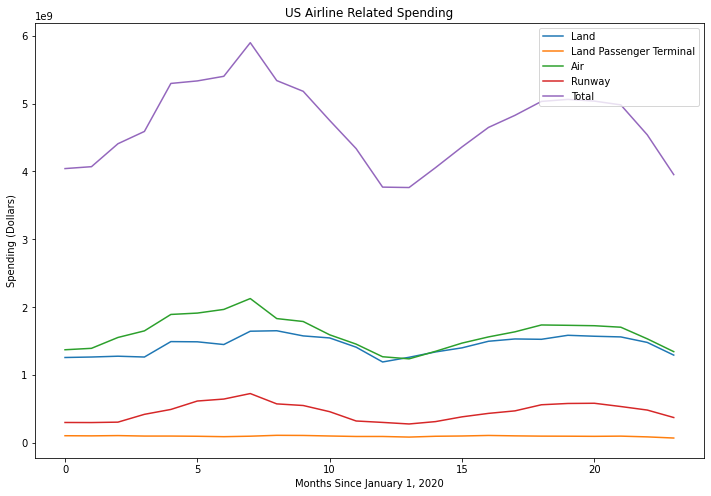

In [ ]:
plt.gcf().set_size_inches(12, 8)
sns.lineplot(x = air_spend.index, y = 'Land', data = air_spend, label = "Land")
sns.lineplot(x = air_spend.index, y = 'Land Passenger Terminal', data = air_spend, label = "Land Passenger Terminal")
sns.lineplot(x = air_spend.index, y = 'Air', data = air_spend, label = "Air")
sns.lineplot(x = air_spend.index, y = 'Runway', data = air_spend, label = "Runway")
sns.lineplot(x = air_spend.index, y = 'Total Spend', data = air_spend, label = "Total")
plt.xlabel('Months Since January 1, 2020')
plt.ylabel('Spending (Dollars)')
plt.legend(prop={'size': 10}, loc='upper right')
plt.title("US Airline Related Spending");

**Analysis + Relevance**: 

We notice that spending falls greatly in all sectors besides land passenger terminal starting at about 5 months after January 1st, 2020. It is likely that the reason land passenger terminal does not fluctuate is that the data used is only for about 2 years, so it is unlikely that land passenger terminals experienced major renovations or investments in this short of time (i.e. this spending is not a yearly or frequent expense). For the other catergories of spending, there is a steady decline until about 11 months after Jan 1, 2020. After this, spending begins to rise until about 19 months after, when it peaks again and begins to fall. 

Given that we are looking to deduce a causal effect of transit investment on usage, this visualization is relevant because now that we know what trends exist in investment, we can compare these to trends in usage to understand their relationship.

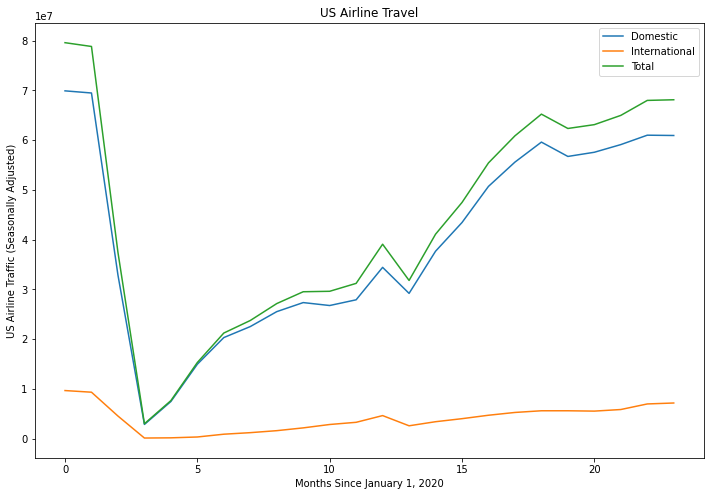

In [ ]:
plt.gcf().set_size_inches(12, 8)
sns.lineplot(x = air_move.index, y = 'U.S. Airline Traffic - Domestic - Seasonally Adjusted', data = air_move, label = "Domestic")
sns.lineplot(x = air_move.index, y = 'U.S. Airline Traffic - International - Seasonally Adjusted', data = air_move, label = "International")
sns.lineplot(x = air_move.index, y = 'Total Move', data = air_move, label = "Total")
#sns.lineplot(x = a.index, y = 'Transit Ridership - Other Transit Modes - Adjusted', data = a, label = 'Other Transit')
plt.xlabel('Months Since January 1, 2020')
plt.ylabel('US Airline Traffic (Seasonally Adjusted)')
plt.title("US Airline Travel");

**Analysis + Relevance**: 

We notice that US domestic airline travel falls greatly from 0 months after Jan 1, 2020 until about 2 months after. This trend is mirrored in US international airline travel as well. After both reach a minimum, they slowly increase over the next 18 months. The green line depicts the summation of both domestic and international travel. 


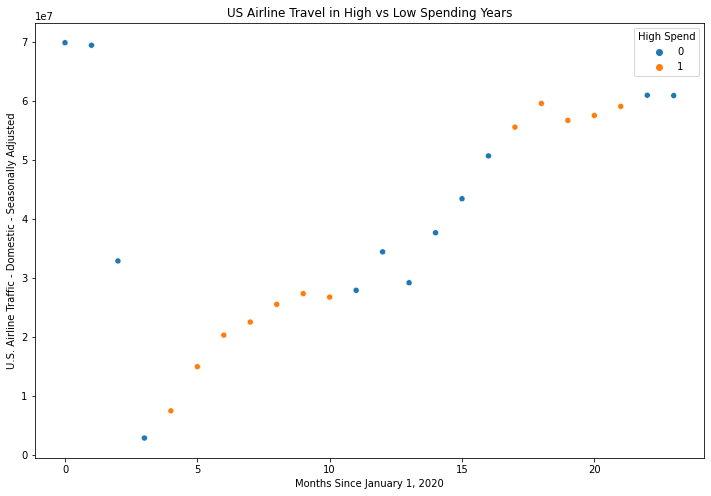

In [ ]:
### A Catergorical Visualization
plt.gcf().set_size_inches(12, 8)
sns.scatterplot(x = air_move.index, y = 'U.S. Airline Traffic - Domestic - Seasonally Adjusted', data = air_move, hue = 'High Spend')
plt.xlabel('Months Since January 1, 2020')
plt.title("US Airline Travel in High vs Low Spending Years");

**Analysis + Relevance**: 

We notice that initially after January 1, 2020 spending is less than average. Spending then rises to above average from 3 months to 8 months after Jan 2020. It then once again falls below average from month 9 to 14, and rises to above average from months 15 to 20. Lastly, it falls beneath average from months 21 to 22. When spending is below average, it appears that the rate of growth in domestiv airline travel is shrinking. On the other hand, in the months of high spending, the rate of growth is large and growing. 

Given that we are looking to deduce a causal effect of transit investment on usage, this visualization is relevant because it can help us understand how investment affects airline travel if we look at above average vs below average spending months. 

**Data Cleaning Steps**:

To clean the data, we imported restricted the government data set to only 2020 onwards. We then found the average total investment in transportation and made a new column indicating if each month had above average or below overage spending. 

#### Results

In [ ]:
!pip install statsmodels==0.13.2

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import statsmodels.api as sm

In [ ]:
# from lab 08
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2)

In [ ]:
linear_model = fit_OLS_model(air_data, 'Total Move', ['Total Spend', 'new_case'], intercept = True)
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Total Move   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1.917
Date:                Tue, 03 May 2022   Prob (F-statistic):              0.172
Time:                        05:22:37   Log-Likelihood:                -437.67
No. Observations:                  24   AIC:                             881.3
Df Residuals:                      21   BIC:                             884.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.166e+08   3.76e+07      3.098      

#### Analysis

For our first model, we used outcome regression to analyze the causal inference of investment on travel. We sought to analyze whether investing more in to airports and related infrastructure for air travel have a causal effect on the number of passengers and airline utilization in general. Given that our data is from recent years, one big confounder on the data is COVID-19. In attempt to deal with this confounder, we added in outside data for the number of COVID-19 cases at the time (from CDC). Our model had a log likelihood of -437.67 (average log likelihoood of -18.23 per data points) and the confidence interval for our total spending coefficient contains zero, suggesting that this model is not a great model of causal inference. 

Some of the assumptions that went into this model include that we assume the relationship between causal variables and outcome variables is linear, which may not be true. Additionaly, our linear model assumes that each regressor affects total travel independently of each other, which may not be true. For example, the number of new covid cases per month may not act independently of the total investment ammount (as sugested by the strong multi-colinearity). It is possible that there are other confounders that are not controlled for in this situation which may be leading to the poor outcome regression model. For example, we attempted to control for COVID through cases but it is possible that other colliders may exist such as lockdown regulations. In addition, international travel may be affected differently because our investment data is only for the United States and not other parts of the world. 

In [ ]:
linear_model2 = fit_OLS_model(air_data, 'Total Move', ['Land Passenger Terminal', 'Land', 'Runway', 'Air Passenger Terminal', 'Air', 'new_case'], intercept = True)
print(linear_model2.summary())

                            OLS Regression Results                            
Dep. Variable:             Total Move   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     3.914
Date:                Tue, 03 May 2022   Prob (F-statistic):             0.0122
Time:                        05:22:37   Log-Likelihood:                -429.27
No. Observations:                  24   AIC:                             872.5
Df Residuals:                      17   BIC:                             880.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

#### Analysis 
In our second model, instead of using total spending, we trained the model with multiple regressors: one for each of the different spending metrics on airlines. Again, we noticed a poor log likelihood value (-429; -17.28 on average per data point). In addition, all of the individual regressors contain zero in the confidence interval, further complicating our analysis of causal inference. 

Part of the challenges with our model is we were inferring that the linear model described and explained the relation ship between these variables; howver, it is possible that this is a non linear relationship. In addition, we assumed that each regressor affected total travel independently of each other, which may not be true. Particularly, because we have a different causal variable for each category of airline investment, we are assuming they each have independent effects -- which is likley not true as each is effected by the total ammount of investment in airlines allocated for that month. Furthermore, both models, are based at the level of months due to the datasets that we were working with. In reality, it is likely that monthly spending on infrastructure does not explain the transportation utilization during the same month. For example, big investment projects may take multiple months for the construction or other improvements to be completed -- meaning the initial investmenit may come months before its effects are seen. It is possible that the completed projects may have a stronger effect on utilization, meaning that the effect of investment may be delayed by a few months.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1d54f865-601e-41ca-88c1-3fe29c0fb07a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>